# FInding a good learning rate

For this project we are using Python, and Jupyter Notebooks hosted on Google Colab. Any Jupyter engine will can be used, but it will require adjustmets to this initial setup to be able to access the raw data and the helper tools. 

To keep the notebook clean, all the implementation details are hidden in a set of helper functions in the file `deeppredict_tools.py`


### Prerequisites for running this Notebook on Google Colab 

We need to mount a Google Drive folder called `deeppredict`, which has the same structure and contents as the repository at https://github.com/dimitardi/deep-predict. 

And the matlab raw data files in the subfolder `DEEPPREDICT_HOME/dataset` (see `deeppredict_0_download_raw_data.ipynb` for how to download these files)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

DEEPPREDICT_HOME = '/content/gdrive/My Drive/deeppredict'

# add the home folder to the python path to be able to import and use the included code
import sys
sys.path.append(DEEPPREDICT_HOME)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install --upgrade -q -r '/content/gdrive/My Drive/deeppredict/requirements.txt'

import skimage as sk
# explicitly check the sci-kit image version
# currently colab has the 0.13 by default, which is too old. It should be at least >= 0.14
sk.__version__

'0.14.2'

### Load up the images, and prepare for training

Load up the file we generated in [this notebook](https://).

In [3]:
from deeppredict_tools import load_images_by_labels_by_params, ImageType

chunk_size = 1200
number_of_chunks=1400
image_types=[ImageType.SPECTROGRAM]
image_shape = (96, 96)
shuffle_chunks_across_time=True

images_by_labels_for_cnn = load_images_by_labels_by_params(
    chunk_size=chunk_size, 
    number_of_chunks=number_of_chunks,     
    image_types=image_types, 
    image_shape=image_shape,
    chunks_are_shuffled_across_time=shuffle_chunks_across_time)

Successfully loaded file /content/gdrive/My Drive/deeppredict/npy_dataset/images_by_labels_for_cnn__chunks1400_size1200_typesSP_timeshuffled_shape96-96.npy


Now, to transform the data to a form suitable for feeding to the CNN, we do :
- separate the images and their labels into two arrays, correlated by their indexes
- have the labels one-hot encoded (i.e. label "N" becomes (0,0,1))

Aditionally, to get a good distribution of data types accross the training and test data, we interleave the three types of data - we get a single array, containing all the images, where sequential images are always having a different data type (N, IR, or B) in the form [ ..., "N", "IR", "B", "N", "IR", "B",  ...]

In [4]:
from deeppredict_tools import separate_images_from_labels

images_for_cnn, labels_for_cnn_onehot = separate_images_from_labels(images_by_labels_for_cnn, interleave=True)

print(images_for_cnn.shape)
print(labels_for_cnn_onehot.shape)

(4200, 96, 96, 4)
(4200, 3)


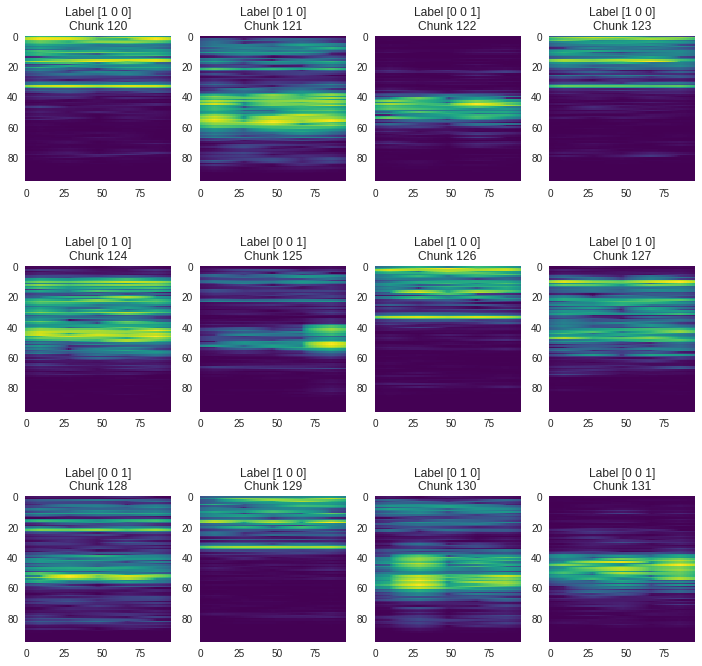

In [5]:
import matplotlib.pyplot as plt

offset = 120  # start at the {offset} chunk, somewhere within the waste of images
plt.rcParams["axes.grid"] = False
fig = plt.figure(figsize=(12, 12))
for i in range(0, 12):
    plt.subplot(3, 4, i+1, title=f'Label {labels_for_cnn_onehot[i+offset]}\nChunk {i+offset}')
    plt.imshow(images_for_cnn[i+offset])
fig.show()

The last step before training is to separate the images into training set and testing set

In [0]:
from sklearn.model_selection import train_test_split

images_train, images_test, labels_train_onehot, labels_test_onehot = \
    train_test_split(
        images_for_cnn, 
        labels_for_cnn_onehot, 
        test_size=0.33, 
        random_state=42)

Now we are ready to run the model

## **Fitting with a dynamically increasing learning rate**

Let's first set the fitting parameters.

In [0]:
BATCH_SIZE = 64
NUMBER_OF_EPOCHS = 30
VALIDATION_SPLIT = 0.25

Set up a consantly increasing learning rate. It is a special case of the **cyclical learning rate** as described at the bottom of the readme from https://github.com/bckenstler/CLR

In [8]:
import math

# cyclic learning rate parameters
LR_CYCLE_MODE = 'triangular'
LR_STEP_SIZE_IN_EPOCHS = NUMBER_OF_EPOCHS  # this means the learning rate will linearly increase between LR_MIN and LR_MAX
LR_MIN = 0.0001
LR_MAX = 0.01

# cyclic learning rate
# Authors suggest setting step_size = (2-8) x (training iterations in epoch)
number_of_samples = int(len(labels_train_onehot) * (1-VALIDATION_SPLIT))
training_iterations_in_epoch = math.ceil(number_of_samples / BATCH_SIZE) 
print(f'Number of samples: {number_of_samples}')
print(f'Size of a batch: {BATCH_SIZE}')
print(f'Number of iterations in epoch: {training_iterations_in_epoch}')
lr_step_size = int(LR_STEP_SIZE_IN_EPOCHS * training_iterations_in_epoch)
print(f'Learning rate step size: {lr_step_size}')

from clr_callback import *

clr_triangular = CyclicLR(
    mode=LR_CYCLE_MODE, 
    step_size=lr_step_size,
    base_lr=LR_MIN, 
    max_lr=LR_MAX)

Number of samples: 2110
Size of a batch: 64
Number of iterations in epoch: 33
Learning rate step size: 990


Using TensorFlow backend.


We need to load the keras CNN model we created and saved [in this notebook](https://)

In [9]:
import keras

model_filename = f'{DEEPPREDICT_HOME}/models/CNN_arch_guo_shape96-96-4-3__initial.h5'
model = keras.models.load_model(model_filename)

history = model.fit(
    images_train, labels_train_onehot,
    batch_size=BATCH_SIZE,
    callbacks=[clr_triangular],
    epochs=NUMBER_OF_EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2110 samples, validate on 704 samples
Epoch 1/30
2110/2110 [==============================] - 3s 1ms/step - loss: 8.3319 - categorical_accuracy: 0.3441 - val_loss: 6.9895 - val_categorical_accuracy: 0.3210
Epoch 2/30
2110/2110 [==============================] - 2s 716us/step - loss: 1.8481 - categorical_accuracy: 0.5995 - val_loss: 0.2380 - val_categorical_accuracy: 0.8807
Epoch 3/30
2110/2110 [==============================] - 2s 715us/step - loss: 0.4481 - categorical_accuracy: 0.7986 - val_loss: 0.0458 - val_categorical_accuracy: 0.9886
Epoch 4/30
2110/2110 [==============================] - 1s 711us/step - loss: 0.2526 - categorical_accuracy: 0.8773 - val_loss: 0.0333 - val_categorical_accuracy: 0.9915
Epoch 5/30
2110/2110 [==================

## Plot the results

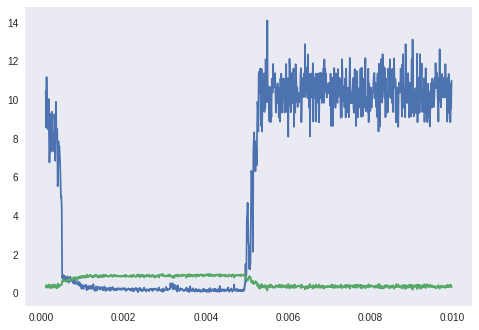

In [10]:
# plotting
import matplotlib.pyplot as plt

from_epoch = 0
to_epoch = NUMBER_OF_EPOCHS
start = training_iterations_in_epoch * from_epoch  # 52 + 10  # to exclude the initial spike in loss
end = training_iterations_in_epoch * to_epoch  # 55  # how many epochs to plot

h = clr_triangular.history
plt.plot(h['lr'][start:end], h['loss'][start:end])
plt.plot(h['lr'][start:end], h['categorical_accuracy'][start:end])

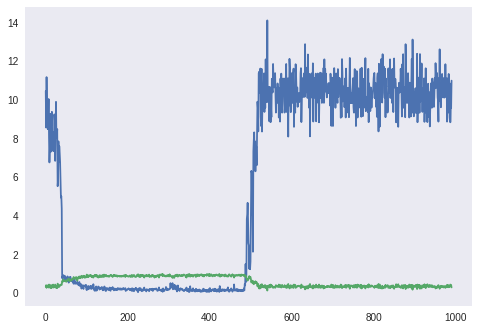

In [11]:
plt.plot(h['iterations'][start:end], h['loss'][start:end])
plt.plot(h['iterations'][start:end], h['categorical_accuracy'][start:end])

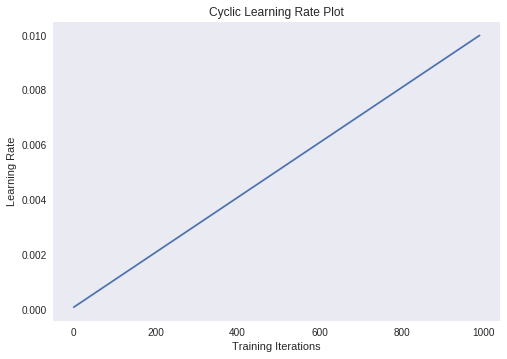

In [12]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("Cyclic Learning Rate Plot")
plt.plot(h['iterations'][start:end], h['lr'][start:end])

We see from these plots that our optimal learning rate is somewhere in the range [0.0015, 0.005]